In [1]:
using Interact, PyPlot

# The power method

We know that multiplying by a matrix $A$ repeatedly will exponentially amplify the largest-|λ| eigenvalue.  This is the basis for many algorithms to compute eigenvectors and eigenvalues, the most basic of which is known as the [power method](https://en.wikipedia.org/wiki/Power_iteration).

The simplest version of this is to just start with a random vector $x$ and multiply it by $A$ repeatedly. (This is the procedure by which a Markov process approaches its steady state!)  This works, but has the practical problem that the vector quickly becomes very large or very small, and eventually becomes too big/small for the computer to represent (this is known as "overflow/underflow").  The fix is easy: *normalize the vector after each multiplication by A*.  That is:

* Starting with a random $x$, repeatedly compute $x \leftarrow Ax / \Vert Ax \Vert $.

For example, let's try it on a random matrix with eigenvalues 1 to 5:

In [2]:
A = randn(5,5)
A = A * diagm(1:5) / A

5×5 Array{Float64,2}:
  2.50462    -0.701339   1.20281   -0.147097  -0.932265 
  0.723968    6.48373    1.16327   -5.53139    0.969304 
 -0.954635   -3.66669    1.72789    6.01789   -1.47526  
 -0.0997186   0.636945   0.671405   1.58586    0.0650827
 -1.77605    -2.47092   -1.86019    5.20735    2.69791  

In [3]:
λ, X = eig(A)
i = sortperm(λ, by=abs, rev=true) # sort the eigenvalues in descending order by magnitude
λ = λ[i]; X = X[:,i]              # and re-order λ and X
λ

5-element Array{Float64,1}:
 5.0
 4.0
 3.0
 2.0
 1.0

Let's look at the result of $n$ steps of the power method side-by-side with the eigenvector $x_1$ (which is normalized to unit length by Julia) for $\lambda = 5$:

In [4]:
x = randn(5)
@manipulate for n = 1:100
    y = x
    for i = 1:n
        y = A*y
        y = y / norm(y)
    end
    [y X[:,1]]
end

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(50, nactions=1),"n",50,"50",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(68=>"68",2=>"2",89=>"89",11=>"11",39=>"39",46=>"46",85=>"85",25=>"25",55=>"55",42=>"42"…)),Any[],Any[],true,"horizontal")

5×2 Array{Float64,2}:
  0.543745    -0.543745  
 -0.526871     0.526869  
  0.563085    -0.563084  
 -0.00975261   0.00975247
 -0.331043     0.331045  

Note that the *sign* of the resulting vector is random, depending on the initial $x$.

We could also plot the difference $\Vert \pm y - x_1 \Vert$ versus the number $n$ of steps:

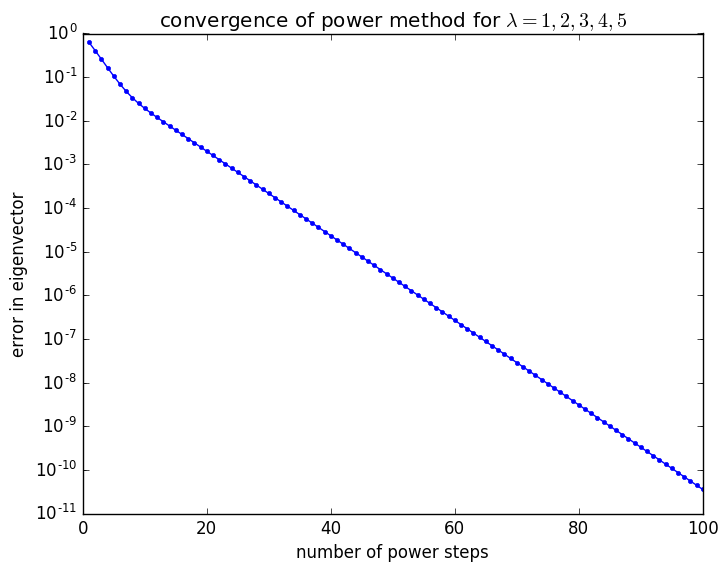

PyObject <matplotlib.text.Text object at 0x32b413650>

In [5]:
d = Float64[]
y = x
for i = 1:100
    y = A*y
    y = y / norm(y)
    push!(d, min(norm(y - X[:,1]), norm(-y - X[:,1]))) # pick the better of the two signs
end
semilogy(1:length(d), d, "b.-")
xlabel("number of power steps")
ylabel("error in eigenvector")
title(L"convergence of power method for $\lambda=1,2,3,4,5$")

# Convergence rate

How fast does the power method converge?

Suppose that $A$ is diagonalizable with eigenvalues sorted in order of decreasing magnitude $$|\lambda_1| > |\lambda_2| > \cdots$$.  And suppose that we expand our initial $x$ in the basis of the eigenvectors:
$$x = c_1 x_1 + c_2 x_2 + \cdots$$
Then, after $n$ steps, the power method produces:

$$
\mbox{scalar multiple of } A^n x = \mbox{multiple of } \left( \lambda_1^n c_1 x_1 + \lambda_2^n c_2 x_2 + \lambda_3^n c_3 x_3 + \cdots \right)
= \mbox{multiple of } \lambda_1^n \left[ c_1 x_1 + (\lambda_2/\lambda_1)^n c_2 x_2 + (\lambda_3/\lambda_1)^n c_3 x_3 + \cdots \right]
$$

The overall exponentially growing (or decaying) term $\lambda_1^n$ gets removed by the normalization.  The key thing is that the $x_2$, $x_3$ and other "error" terms not proportional to $x_1$ decay like the *ratios* of their eigenvalues/λ₁to the n-th power.   

For large $n$ the error is dominated by the $x_2$ term (the *next*-biggest |λ|), since that term decays most slowly, and the magnitude of this term decays proportional to $|\lambda_2/\lambda_1|^n$: the *ratio* of the magnitudes. 

For example, in our case above, we'd expect the error to decay proportional to $(4/5)^n$:

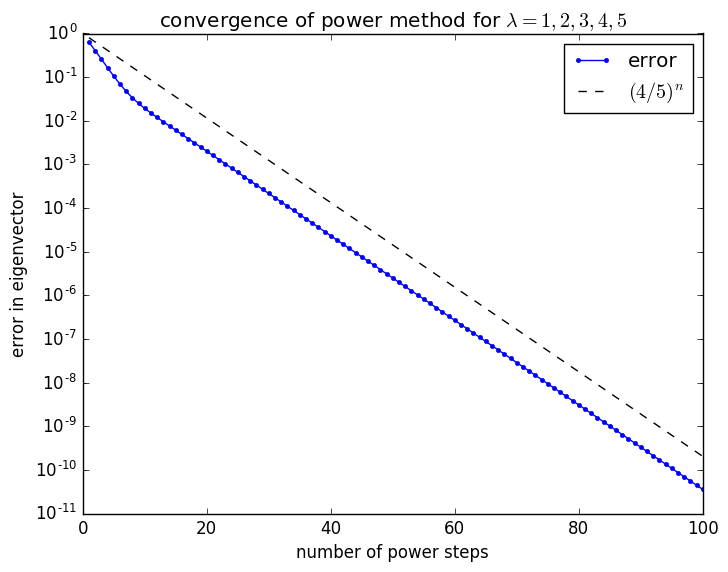

PyObject <matplotlib.legend.Legend object at 0x32b6ccb50>

In [6]:
semilogy(1:length(d), d, "b.-")
semilogy(1:length(d), (4/5).^(1:length(d)), "k--")
xlabel("number of power steps")
ylabel("error in eigenvector")
title(L"convergence of power method for $\lambda=1,2,3,4,5$")
legend(["error", L"(4/5)^n"])

# Pros/cons of the power method

* Our analysis shows that the power method can converge very slowly if $|\lambda_2/\lambda_1|$ is close to 1.  And if two eigenvalues have *equal* magnitude, the method may not converge *at all*.

* Also, it only gives us $x_1$.  What if we want $x_2$, or in general a *few* of the biggest-|λ| eigenvectors?

Still, the power method is the **starting point for many more sophisticated methods,** including the [Arnoldi method](https://en.wikipedia.org/wiki/Arnoldi_iteration) (which gives a few of the biggest eigenvectors) or the [QR algorithm](https://en.wikipedia.org/wiki/QR_algorithm) which gives *all* of the eigenvectors.

And the power method *by itself* can still be a pretty good method if we know that one eigenvalue is bigger than all of the others, e.g. for Markov matrices.  And because it is so simple, the power method is easy to apply in lots of different cases, especially since:

* The power method only requires you to supply a "black box" that **multiplies matrix × vector**  This is a *huge* advantage for problems where the matrix is *mostly zeros* (or has some other special structure), in which you can multiply **matrix × vector much more quickly than for a generic matrix**.

In homework, you will look at how Markov matrices relate to the [Google PageRank](https://en.wikipedia.org/wiki/PageRank).  Google actually runs this algorithm on a *huge* Markov matrix where rows/cols are *web pages*: the matrix is [*over a billion by billion entries*](https://www.mathworks.com/content/dam/mathworks/mathworks-dot-com/moler/exm/chapters/pagerank.pdf).  But since most web pages only link to a few other pages, the matrix is mostly zeros, and you can multiply it by a random vector in a few billion operation, rather than a billion² operations.  (They don't even store the whole matrix: you only store the nonzero entries of such a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix).)

# Getting an eigenvalue from the eigenvector

In the textbook method of solving eigenproblems, we first find the eigenvalues from the roots of the characteristic polynomial, and then we find the eigenvectors from $N(A - \lambda I)$ for each eigenvalue.

The power method, however, gives you an eigenvector first!  How do you find the eigenvalue?  And how do you find an *approximate* eigenvalue given the *approximate* eigenvector that you get from a *finite* number of iterations.

For example, suppose that we do 30 iterations on the example above:

In [7]:
y = x
for i = 1:30
    y = A*y
    y = y / norm(y)
end
y

5-element Array{Float64,1}:
  0.543704  
 -0.52698   
  0.563124  
 -0.00976376
 -0.330869  

If $y$ was the *exact* eigenvector, we could just multiply $Ay$ and see how much each component increased: they would all increase (or decrease) by the same factor λ.

But, for an approximate eigenvector, each component of $Ay$ will increase by a slightly different amount:

In [8]:
(A*y) ./ y   # divide each element of Ay elementwise (./ in Julia) by the corresponding element of y

5-element Array{Float64,1}:
 5.00012
 4.99984
 4.99998
 4.99891
 5.00058

These are all pretty close to the true eigenvalue λ=5, but don't quite agree.  Clearly, we need some kind of average?

A problem with dividing things elementwise is that some of the eigenvector elements might be zero (or nearly zero), and then our estimate will go crazy.  Instead, we need to take the average in some other way.

Instead, the most common approach is to use the [Rayleigh quotient](https://en.wikipedia.org/wiki/Rayleigh_quotient):

$$
\lambda \approx \frac{y^T A y}{y^T y}
$$

where $y$ is our estimated eigenvector.  If we have an exact eigenvector, so that $Ay = \lambda y$, then the Rayleigh quotient will gives us exactly $\lambda$.  Otherwise, it is a kind of weighted-average (weighted by the components $y_k^2$), and is a reasonable approximation:

In [9]:
dot(y, A*y) / dot(y,y) # a Rayleigh quotient in Julia

5.000046834247057

Clearly, this is a pretty good estimate for the true eigenvalue 5.   Let's see how it converges by plotting the error as a function of the number of power iterations:

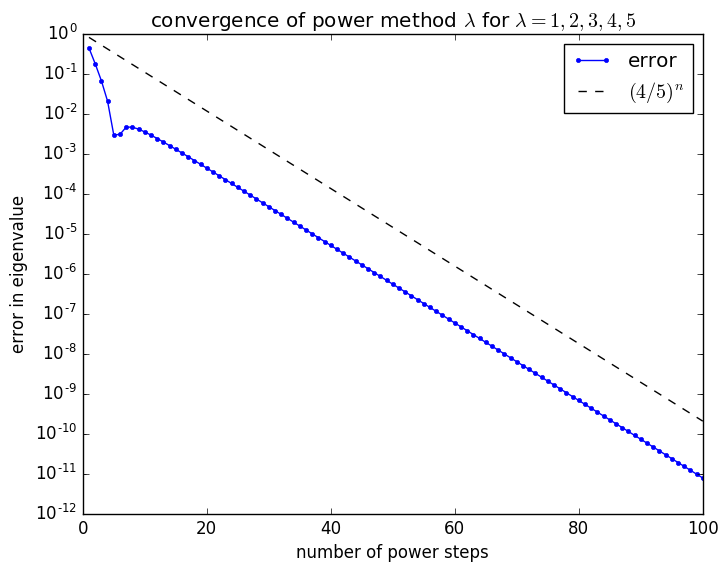

PyObject <matplotlib.legend.Legend object at 0x31fe4e650>

In [10]:
Δλ = Float64[]
y = x
for i = 1:100
    y = A*y
    y = y / norm(y)
    λ̃ = dot(y, A*y) / dot(y,y)
    push!(Δλ, abs(λ̃ - 5))
end
semilogy(1:length(Δλ), Δλ, "b.-")
semilogy(1:length(Δλ), (4/5).^(1:length(Δλ)), "k--")
xlabel("number of power steps")
ylabel("error in eigenvalue")
title(L"convergence of power method $\lambda$ for $\lambda=1,2,3,4,5$")
legend(["error", L"(4/5)^n"])

It is converging at the same rate.

(For symmetric matrices, it turns out that the eigenvalue converges even faster than the eigenvalue, but that is not a topic for 18.06.)